In [83]:
#!/usr/local/bin/python3.7
from IPython import get_ipython
get_ipython().magic('reset -sf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import reverse_geocoder as rg
import os, netCDF4
os.chdir('/Users/hausfath/Desktop/Climate Science/daily_records/')

#Berkeley Earth daily equal area tmax and tmin file paths
tmax_file = 'Complete_TMAX_Daily_EqualArea.nc'
tmin_file = 'Complete_TMIN_Daily_EqualArea.nc'

In [112]:
def import_berkeley(filename, verbose = False):
    '''
    Import Berkeley Earth daily equal area NetCDF data 
    '''
    nc = netCDF4.Dataset(filename, 'r')
    lats = nc.variables['latitude'][:]
    lons = nc.variables['longitude'][:]
    temps = nc.variables['temperature'][:,:]
    year = nc.variables['year'][:]
    dofy = nc.variables['day_of_year'][:]
    land_mask = nc.variables['land_mask'][:]
    return {
        'lats' : lats,
        'lons' : lons,
        'temps' : temps,
        'year'  : year,
        'dofy' : dofy,
        'land_mask' : land_mask
    }


def sum_records(temps, dofy, record_type, land_mask, use_land_mask):
    '''
    Create a count of the number of min or max records in each year,
    iterating through each day of the year.
    '''
    records = np.zeros(141)
    for x in range(temps.shape[0]): 
        for y in np.arange(1,366):
            if record_type == 'max':
                pos = np.argmax(temps[x][dofy==y])
            elif record_type == 'min':
                pos = np.argmin(temps[x][dofy==y])
            if use_land_mask == True:
                records[pos] += 1*land_mask[x]
            else:
                records[pos] += 1
        
    year = np.arange(1880,2021)
    results = pd.DataFrame()
    results['year'] = year
    results['records'] = records
    return results


def remove_leap_days(data):
    '''
    Identify leap years, and return a version of the data where the 60th day of the
    year (e.g. February 29th) is removed during leap years. Create a new day-of-year 
    field where all years have 365 unique days.
    '''
    df = pd.DataFrame()
    df['leap_day'] = np.full((len(data['year'])), False)
    df['year'] = data['year']
    df['dofy'] = data['dofy']

    for year in np.arange(1880,2021):
        if len(df['dofy'][df['year']==year]) == 366:
            df.loc[(df['year'] == year) & (df['dofy'] == 60), 'leap_day'] = True
    
    leap_days = df['leap_day'].copy()
    df = df[np.invert(df['leap_day'])]

    for year in np.arange(1880,2021):
        if year == 2020:
            #Fix for daily data only including the first 305 days of 2020
            df.loc[(df['year'] == year), 'dofy'] = np.arange(1,len(df.loc[(df['year'] == year)])+1) 
        elif any(df['dofy'][df['year']==year].duplicated()):
            df.loc[(df['year'] == year), 'dofy'] = np.arange(1,366)
    
    return {
        'lats' : data['lats'],
        'lons' : data['lons'],
        'land_mask' : data['land_mask'],
        'temps' : data['temps'][np.invert(leap_days)],
        'year'  : df['year'].values,
        'dofy' : df['dofy'].values
    }

In [150]:
#Specify record type and region
record_type = 'min' #'min' or 'max'
region = 'global' #'conus', 'us', or 'global'
use_land_mask = True

#Import daily data for the record type
if record_type == 'max':
    data = import_berkeley(tmax_file)
elif record_type == 'min':
    data = import_berkeley(tmax_file)
    
#Remove leap days
data = remove_leap_days(data)

#Swap axes to put grid cell before date
data['temps'] = np.swapaxes(data['temps'], 0, 1)

#Geocode each grid cell with its country/state data
coords = list(zip(data['lats'],data['lons']))
geocords = pd.DataFrame(rg.search((coords), verbose=False))

#Select based on the specified region
if region == 'conus':
    geocords['conus'] = (geocords['cc'].eq('US') & geocords['admin1'].ne('Alaska') & geocords['admin1'].ne('Hawaii'))
    temps = data['temps'][geocords['conus'].values]
    land_mask = data['land_mask'][geocords['conus'].values]
elif region == 'us':
    geocords['us'] = (geocords['cc'].eq('US'))
    temps = data['temps'][geocords['us'].values]
    land_mask = data['land_mask'][geocords['us'].values]
elif region == 'global':
    temps = data['temps']
    land_mask = data['land_mask']

#Calculate records per year and save the results to a csv file
results = sum_records(temps, data['dofy'], record_type, land_mask, use_land_mask)
results.to_csv(region+'_'+record_type+'.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


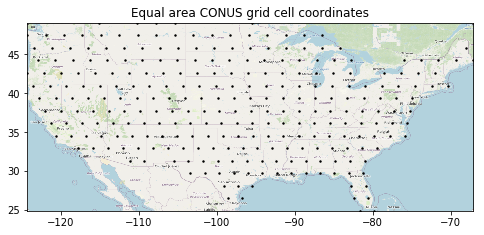

In [6]:
#Map the location of equal area gridcells
coords = pd.DataFrame(list(zip(data['lats'][geocords['conus'].values],data['lons'][geocords['conus'].values])))
coords.rename(columns={coords.columns[0]: 'lats', coords.columns[1]: 'lons'}, inplace=True)
bbox = ((coords['lons'].min(), coords['lons'].max(), coords['lats'].min(), coords['lats'].max()))
conus_map = plt.imread('conus map.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(coords['lons'], coords['lats'], zorder=1, alpha= 1, c='black', s=2)
ax.set_title('Equal area CONUS grid cell coordinates')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(conus_map, zorder=0, extent = bbox, aspect= 'equal')

In [119]:
#Note: CONUS complete 1895 onward. Full US complete 1905 onward.

In [14]:
#Helpful code for reading NetCDF files:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr, repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print( "NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print( '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print( "NetCDF dimension information:")
        for dim in nc_dims:
            print( "\tName:", dim)
            print( "\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print( "NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print( '\tName:', var)
                print( "\t\tdimensions:", nc_fid.variables[var].dimensions)
                print( "\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars
nc = netCDF4.Dataset(tmax_file, 'r')
nc_attrs, nc_dims, nc_vars = ncdump(nc)

NetCDF Global Attributes:
	Conventions: 'Berkeley Earth Internal Convention (based on CF-1.5)'
	title: 'Native Format Berkeley Earth Surface Temperature Anomaly Field'
	history: '30-Mar-2021 15:31:35'
	institution: 'Berkeley Earth Surface Temperature Project'
	source_history: '30-Mar-2021 08:09:47'
	comment: 'This file contains Berkeley Earth surface temperature anomaly field in our native equal-area format.'
NetCDF dimension information:
	Name: map_points
		size: 5498
	Name: time
		size: 51439
	Name: day_number
		size: 365
NetCDF variable information:
	Name: longitude
		dimensions: ('map_points',)
		size: 5498
		type: dtype('float32')
		units: 'degrees_east'
		standard_name: 'longitude'
		long_name: 'Longitude'
	Name: latitude
		dimensions: ('map_points',)
		size: 5498
		type: dtype('float32')
		units: 'degrees_north'
		standard_name: 'latitude'
		long_name: 'Latitude'
	Name: date_number
		dimensions: ('time',)
		size: 51439
		type: dtype('float64')
		units: 'year A.D.'
		long_name: '